# Importing and manipulating data with Pandas
An initial analysis of AirBnB listings in Brussels.

In [14]:
# this cell contains our library imports
import pandas as pd
import altair as alt
import geopandas as geopandas

alt.data_transformers.disable_max_rows()
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [15]:
data = pd.read_csv('listings_brussels_20190813.csv')

## Clean up the data a bit and calculate occupancy information

In [16]:
data = data.query('price < 600') # entries over 600 euro are likely typos or hosts that misunderstood the platform
data = data.query('reviews_per_month > 0 & last_review > "2018-07-31"') # we remove any listings with zero reviews for now to focus only on 'active' listings

In [17]:
def calculate_occupancy_rate(number_of_reviews, minimum_nights):
    # first we set some additional assumptions
    review_rate = 0.5
    days_in_month = 31
    average_stay_length_assumption = 3
    max_occupancy = 0.7

    # calculate occupancy
    average_stay_length = minimum_nights.clip(lower = average_stay_length_assumption)
    occupancy_per_month = number_of_reviews / review_rate * average_stay_length / days_in_month
    
    # cap occupancy at max_occupancy
    exceed_max_occupancy = occupancy_per_month > max_occupancy
    
    occupancy_per_month.loc[exceed_max_occupancy] = 0.7

    # fill missing values with a zero (0)
    occupancy_per_month_fillna = occupancy_per_month.fillna(0)

    return occupancy_per_month_fillna

In [18]:
data['occupancy_rate'] = calculate_occupancy_rate(data['reviews_per_month'], data['minimum_nights'])
data['monthly_rental_income'] =  data['price'] * data['occupancy_rate'] * 31

## Ready to roll

In [19]:
data

id                                               name    host_id  \
0         2352  Triplex-2chmbrs,grande sdb,terrasse= tous confort       2582   
1         2354                COURT/Long- 1chmb+1salon+sdd+terras       2582   
2        42521  Ixelles: spacious bedroom+boudoir+ensuite bath...     185699   
3        45145                       B&B Welcome to my place -  2     199370   
5        52796                 Bright apartment in Ixelles/Louise     244722   
...        ...                                                ...        ...   
8830  37472109                       La guarida de Cinquantenaire  282690578   
8839  37490590   Appartement 75m² lumineux & cosy - Saint Antoine   26375325   
8849  37522158  appartement sympathique dans le quartier d'Ixe...  190430531   
8864  37561594         Bright apartment in the historical center.  283734248   
8878  37619879  Very Confortable room in vibrant area of Brussels    7374840   

     host_name          neighbourhood  latitude  longitude        room_type  \
0          Oda   Molenbeek-Saint-Jean  50.85787    4.30809  Entire home/apt   
1          Oda   Molenbeek-Saint-Jean  50.85697    4.30651  Entire home/apt   
2       Claire                Ixelles  50.81929    4.38790     Private room   
3        Erick  Saint-Josse-ten-Noode  50.85300    4.36971     Private room   
5       Pierre                Ixelles  50.83356    4.36027  Entire home/apt   
...        ...                    ...       ...        ...              ...   
8830   Antonio              Bruxelles  50.84451    4.39488  Entire home/apt   
8839    Pierre              Etterbeek  50.83065    4.38724  Entire home/apt   
8849    Pierre                Ixelles  50.82105    4.38667     Private room   
8864       Max              Bruxelles  50.84614    4.35407  Entire home/apt   
8878    Sabine                Ixelles  50.83417    4.36558     Private room   

      price  minimum_nights  number_of_reviews last_review  reviews_per_month  \
0        93               2                 15  2018-12-31               0.23   
1        78               2                  2  2018-10-28               0.05   
2        45               2                130  2019-07-28               1.19   
3        70               2                  3  2019-04-08               0.03   
5        74               5                 96  2019-07-20               0.93   
...     ...             ...                ...         ...                ...   
8830     40               1                  1  2019-08-07               1.00   
8839     65               2                  1  2019-08-11               1.00   
8849     28               1                  1  2019-08-07               1.00   
8864     70               2                  1  2019-08-10               1.00   
8878     55               1                  1  2019-08-11               1.00   

      availability_365  occupancy_rate  monthly_rental_income  
0                  229        0.044516                 128.34  
1                  340        0.009677                  23.40  
2                  283        0.230323                 321.30  
3                  190        0.005806                  12.60  
5                  326        0.300000                 688.20  
...                ...             ...                    ...  
8830                 2        0.193548                 240.00  
8839                56        0.193548                 390.00  
8849                69        0.193548                 168.00  
8864               122        0.193548                 420.00  
8878               213        0.193548                 330.00  

[5899 rows x 16 columns]

# Read geographic file foramts

<AxesSubplot:>

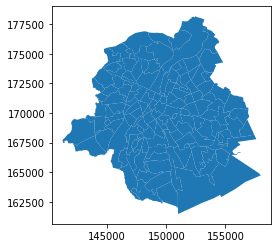

In [20]:
districts = geopandas.read_file('URBIS_ADM_MD/UrbAdm_MONITORING_DISTRICT.shp')
districts.plot()

# Converting tabular data to geographic data

<AxesSubplot:>

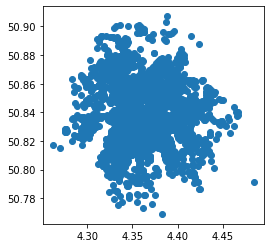

In [21]:
data_geo = geopandas.GeoDataFrame(data, geometry = geopandas.points_from_xy(data['longitude'], data['latitude']), crs = 'EPSG:4326')
data_geo.plot()

# Spatial join & projections

In [22]:
districts = districts.to_crs(data_geo.crs)
data_geo_district = geopandas.sjoin(data_geo, districts)
stats_per_district = data_geo_district.groupby('ID')['monthly_rental_income'].agg(['count', 'mean', 'sum']).reset_index()
districts_stats = districts.merge(stats_per_district, on = 'ID')

# Visualizing spatial data (again)

<AxesSubplot:>

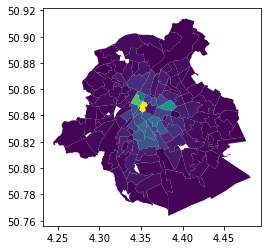

In [23]:
districts_stats.plot(column = 'sum')